# Ecommerce Advertisements Click Through Rate Prediction Using LightGBM

An advertising corporation selects the most possible visitors who are most likely to respond to the advertisements by analysing their browsing history and presenting the most relevant ads depending on the user's interest by estimating the click-through rate.

- id: ad identifier
- click: 0/1 for non-click/click
- hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
- C1 -- anonymized categorical variable
- banner_pos
- site_id
- site_domain
- site_category
- app_id
- app_domain
- app_category
- device_id
- device_ip
- device_model
- device_type
- device_conn_type
- C14-C21 -- anonymized categorical variables

![EDA](https://stretaildemodev.blob.core.windows.net/notebookimages/human-hand-presses-button-head-up-display_1441-958.jpg.webp)

In [1]:
import numpy as np
import random
from io import BytesIO
from azure.storage.blob import ContainerClient, BlobClient
import GlobalVariables as gv
import pandas as pd
n = 40428967  #total number of records in the clickstream data 
sample_size = 1000000
skip_values = sorted(random.sample(range(1,n), n-sample_size)) 

types_train = {
    'id': np.dtype(int),
    'click': np.dtype(int),
    'hour': np.dtype(int),
    'C1': np.dtype(int),
    'banner_pos': np.dtype(int),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(int),
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),
    'C15': np.dtype(int),
    'C16': np.dtype(int),
    'C17': np.dtype(int),
    'C18': np.dtype(int),
    'C19': np.dtype(int),
    'C20': np.dtype(int),
    'C21':np.dtype(int)
}

types_test = {
    'id': np.dtype(int),
    'hour': np.dtype(int),
    'C1': np.dtype(int),
    'banner_pos': np.dtype(int),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(int),
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),
    'C15': np.dtype(int),
    'C16': np.dtype(int),
    'C17': np.dtype(int),
    'C18': np.dtype(int),
    'C19': np.dtype(int),
    'C20': np.dtype(int),
    'C21':np.dtype(int)
}

In [2]:
blob = BlobClient.from_connection_string(conn_str=gv.STORAGE_ACCOUNT_CONNECTION_STRING, container_name='retail-notebook-data', blob_name='click-through.gz')
blob_data = blob.download_blob()
# print(BytesIO(blob_data.content_as_bytes()))
# tx_data = pd.read_csv(BytesIO(blob_data.content_as_bytes()), encoding= 'unicode_escape')

# with gzip.open(BytesIO(blob_data.content_as_bytes()) as f:
#     train = pd.read_csv(f, parse_dates = ['hour'], date_parser = parse_date, dtype=types_train, skiprows = skip_values)

In [3]:
import gzip
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
with gzip.open(BytesIO(blob_data.content_as_bytes())) as f:
    train = pd.read_csv(f, parse_dates = ['hour'], date_parser = parse_date, dtype=types_train, skiprows = skip_values)

In [4]:
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10012820175855462623,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15707,320,50,1722,0,35,-1,79
1,10015405794859644629,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,100084,79
2,1001795364355496701,0,2014-10-21,1005,1,b7e9786d,b12b9f85,f028772b,ecad2386,7801e8d9,...,1,0,19771,320,50,2227,0,687,100081,48
3,10022915835050310266,0,2014-10-21,1005,1,5b4d2eda,16a36ef3,f028772b,ecad2386,7801e8d9,...,1,0,20362,320,50,2333,0,39,100076,157
4,10034702490483278389,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,-1,79


In [5]:
train.shape

(1000000, 24)

In [6]:
train.dtypes

id                          uint64
click                        int64
hour                datetime64[ns]
C1                           int64
banner_pos                   int64
site_id                     object
site_domain                 object
site_category               object
app_id                      object
app_domain                  object
app_category                object
device_id                   object
device_ip                   object
device_model                object
device_type                  int64
device_conn_type             int64
C14                          int64
C15                          int64
C16                          int64
C17                          int64
C18                          int64
C19                          int64
C20                          int64
C21                          int64
dtype: object

Target feature -> click

site features -> site_id, site_domain, site_category

app feature -> app_id, app_domain, app_category

device feature -> device_id, device_ip, device_model, device_type, device_conn_type

anonymized categorical features -> C14-C21

In [7]:
train['click'].value_counts()

0    830504
1    169496
Name: click, dtype: int64

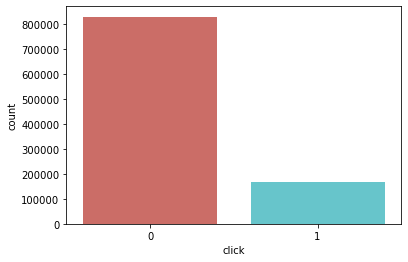

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='click',data=train, palette='hls')
plt.show();

In [9]:
train['click'].value_counts()/len(train)

0    0.830504
1    0.169496
Name: click, dtype: float64

Click through rate is approx. 17%, and approx. 83% is not clicked. 

In [10]:
train.hour.describe()

count                 1000000
unique                    240
top       2014-10-22 09:00:00
freq                    10977
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

The data covers 10 days of click streams data from 2014-10-21 to 2014-10-30, that is 240 hours.

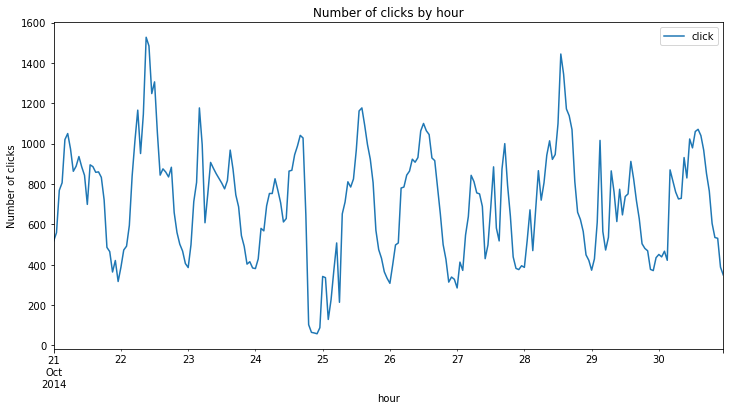

In [11]:
train.groupby('hour').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour');

The hourly clicks pattern looks pretty similar every day. However, there were a couple of peak hours, one is sometime in the mid of the day on Oct 22, and another is sometime in the mid of the day on Oct 28. And one off-peak hour is close to mid-night on Oct 24.

###  Feature engineering for date time features

#### Hour

Extract hour from date time feature.

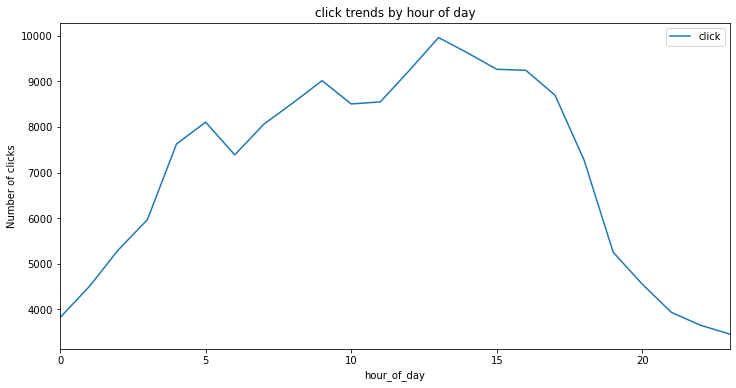

In [12]:
train['hour_of_day'] = train.hour.apply(lambda x: x.hour)
train.groupby('hour_of_day').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('click trends by hour of day');

In general, the highest number of clicks is at hour 13 and 14 (1pm and 2pm), and the least number of clicks is at hour 0 (mid-night). It seems a useful feature for roughly estimation.

In [13]:
train.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day
0,10012820175855462623,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,0,15707,320,50,1722,0,35,-1,79,0
1,10015405794859644629,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,0,15701,320,50,1722,0,35,100084,79,0
2,1001795364355496701,0,2014-10-21,1005,1,b7e9786d,b12b9f85,f028772b,ecad2386,7801e8d9,...,0,19771,320,50,2227,0,687,100081,48,0


Let's take impressions into consideration.

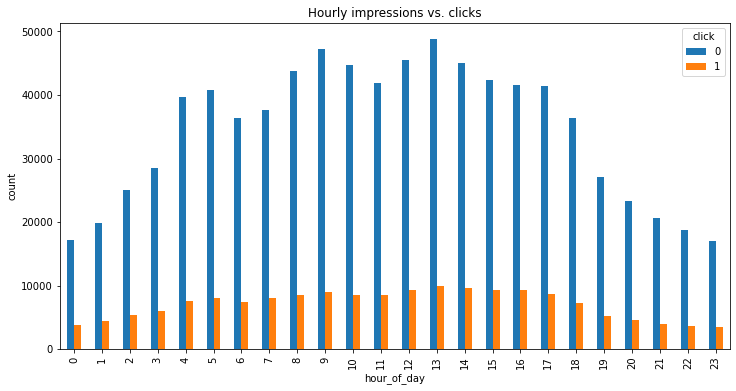

In [14]:
train.groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar', title="Hour of Day", figsize=(12,6))
plt.ylabel('count')
plt.title('Hourly impressions vs. clicks');

There is nothing shocking here.

In [15]:
train.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day
0,10012820175855462623,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,0,15707,320,50,1722,0,35,-1,79,0
1,10015405794859644629,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,0,15701,320,50,1722,0,35,100084,79,0
2,1001795364355496701,0,2014-10-21,1005,1,b7e9786d,b12b9f85,f028772b,ecad2386,7801e8d9,...,0,19771,320,50,2227,0,687,100081,48,0


Now that we have click and impression. We can calculate Click-through rate (CTR). CTR is the ratio of ad clicks to impressions. It measures the rate of clicks on each ad.

#### Hourly CTR

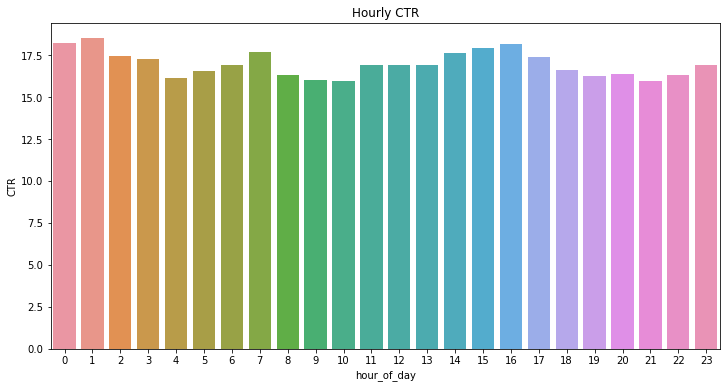

In [16]:
import seaborn as sns

df_click = train[train['click'] == 1]
df_hour = train[['hour_of_day','click']].groupby(['hour_of_day']).count().reset_index()
df_hour = df_hour.rename(columns={'click': 'impressions'})
df_hour['clicks'] = df_click[['hour_of_day','click']].groupby(['hour_of_day']).count().reset_index()['click']
df_hour['CTR'] = df_hour['clicks']/df_hour['impressions']*100

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='hour_of_day', data=df_hour)
plt.title('Hourly CTR');

One of the interesting observations here is that the highest CTR happened in the hour of mid-night, 1, 7 and 15. If you remember, around mid-night has the least number of impressions and clicks.

#### Day of week

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  """Entry point for launching an IPython kernel.


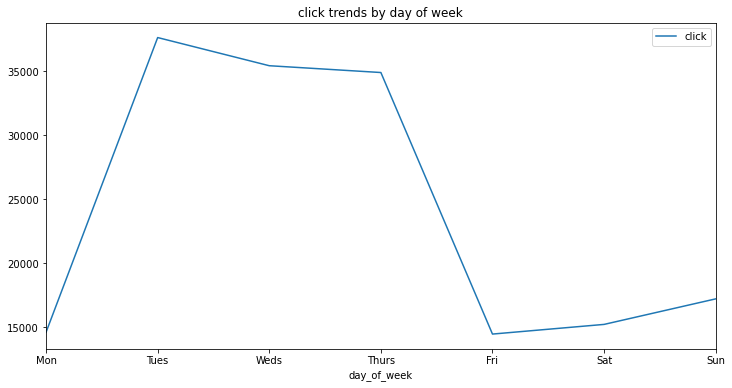

In [17]:
train['day_of_week'] = train['hour'].apply(lambda val: val.weekday_name)
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train.groupby('day_of_week').agg({'click':'sum'}).reindex(cats).plot(figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('click trends by day of week');

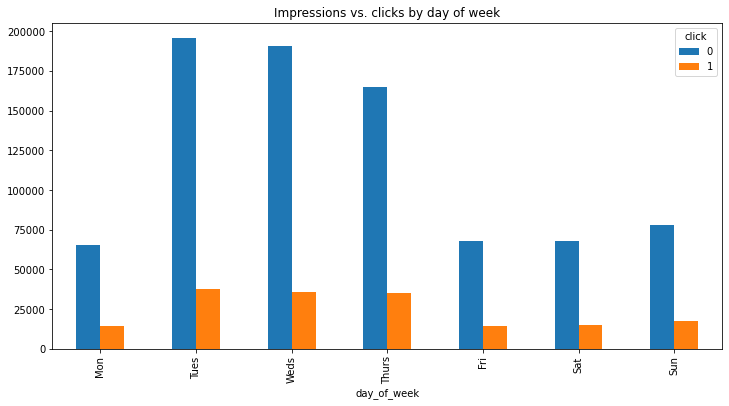

In [18]:
train.groupby(['day_of_week','click']).size().unstack().reindex(cats).plot(kind='bar', title="Day of the Week", figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('Impressions vs. clicks by day of week');

Tuesdays have the most impressions and clicks, then Wednesdays, followed by Thursdays. Mondays and Fridays have the least number of impressions and clicks.

#### Day of week CTR

In [19]:
train.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week
0,10012820175855462623,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,15707,320,50,1722,0,35,-1,79,0,Tuesday
1,10015405794859644629,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,15701,320,50,1722,0,35,100084,79,0,Tuesday
2,1001795364355496701,0,2014-10-21,1005,1,b7e9786d,b12b9f85,f028772b,ecad2386,7801e8d9,...,19771,320,50,2227,0,687,100081,48,0,Tuesday


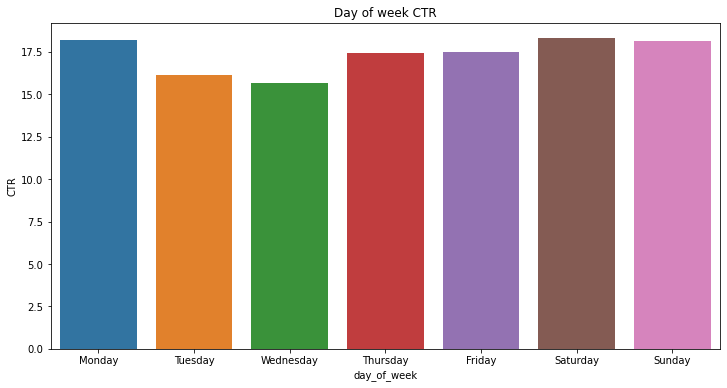

In [20]:
df_click = train[train['click'] == 1]
df_dayofweek = train[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'click': 'impressions'})
df_dayofweek['clicks'] = df_click[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()['click']
df_dayofweek['CTR'] = df_dayofweek['clicks']/df_dayofweek['impressions']*100

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='day_of_week', data=df_dayofweek, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Day of week CTR');

While Tuesdays and Wednesdays have the highest number of impressions and clicks, their CTR are among the lowest. Saturdays and Sundays enjoy the highest CTR. Apparently, people have more time to click over the weekend.

In [21]:
train.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week
0,10012820175855462623,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,15707,320,50,1722,0,35,-1,79,0,Tuesday
1,10015405794859644629,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,15701,320,50,1722,0,35,100084,79,0,Tuesday
2,1001795364355496701,0,2014-10-21,1005,1,b7e9786d,b12b9f85,f028772b,ecad2386,7801e8d9,...,19771,320,50,2227,0,687,100081,48,0,Tuesday


### C1 feature

C1 is one of the anonymized categorical features. Although we don't know its meaning, we still want to have a look its distribution.

In [22]:
print(train.C1.value_counts()/len(train))

1005    0.918964
1002    0.054711
1010    0.022367
1012    0.002718
1007    0.000889
1001    0.000226
1008    0.000125
Name: C1, dtype: float64


C1 value = 1005 has the most data, almost 92%. Let's see whether we can find value of C1 indicates something about CTR.

In [23]:
C1_values = train.C1.unique()
C1_values.sort()
ctr_avg_list=[]
for i in C1_values:
    ctr_avg=train.loc[np.where((train.C1 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C1 value: {},  click through rate: {}".format(i,ctr_avg))

for C1 value: 1001,  click through rate: 0.03982300884955752
for C1 value: 1002,  click through rate: 0.21092650472482682
for C1 value: 1005,  click through rate: 0.16896091685854941
for C1 value: 1007,  click through rate: 0.043869516310461196
for C1 value: 1008,  click through rate: 0.104
for C1 value: 1010,  click through rate: 0.09657084097107346
for C1 value: 1012,  click through rate: 0.1714495952906549


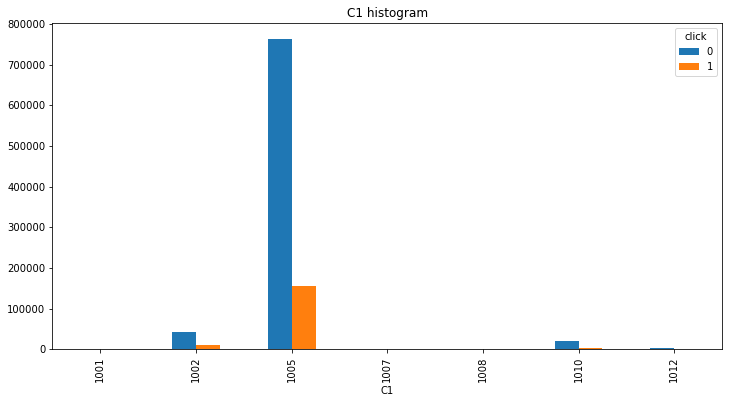

In [24]:
train.groupby(['C1', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C1 histogram');

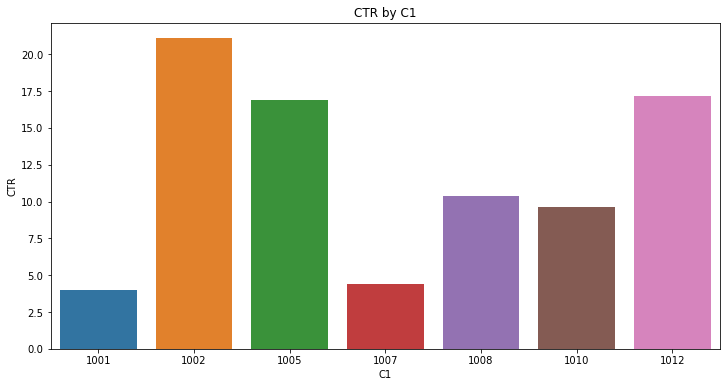

In [25]:
df_c1 = train[['C1','click']].groupby(['C1']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C1','click']].groupby(['C1']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='C1', data=df_c1)
plt.title('CTR by C1');

The average CTR in the data is 0.17.

In [26]:
train['click'].mean()

0.169496

In [27]:
df_c1.CTR.describe()

count     7.000000
mean     11.937148
std       6.625484
min       3.982301
25%       7.022018
50%      10.400000
75%      17.020526
max      21.092650
Name: CTR, dtype: float64

The important C1 values and CTR pairs are:

1005: 92% of the data and 0.17 CTR

1002: 5.5% of the data and 0.21 CTR

1010: 2.3% of the data and 0.096 CTR

1002 has a much higher than average CTR, and 1010 has a much lower than average CTR, it seems these two C1 values are important for predicting CTR.

### Banner position

I have heard that there are many factors that affect the performance of your banner ads, but the most influential one is the banner position. Let's see whether it is true.

In [28]:
print(train.banner_pos.value_counts()/len(train))

0    0.718930
1    0.279348
7    0.001068
2    0.000291
4    0.000192
5    0.000125
3    0.000046
Name: banner_pos, dtype: float64


In [29]:
banner_pos = train.banner_pos.unique()
banner_pos.sort()
ctr_avg_list=[]
for i in banner_pos:
    ctr_avg=train.loc[np.where((train.banner_pos == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for banner position: {},  click through rate: {}".format(i,ctr_avg))

for banner position: 0,  click through rate: 0.16366683821790717
for banner position: 1,  click through rate: 0.18394976874722568
for banner position: 2,  click through rate: 0.14432989690721648
for banner position: 3,  click through rate: 0.1956521739130435
for banner position: 4,  click through rate: 0.171875
for banner position: 5,  click through rate: 0.104
for banner position: 7,  click through rate: 0.3258426966292135


The important banner positions are:

position 0: 72% of the data and 0.16 CTR

position 1: 28% of the data and 0.18 CTR

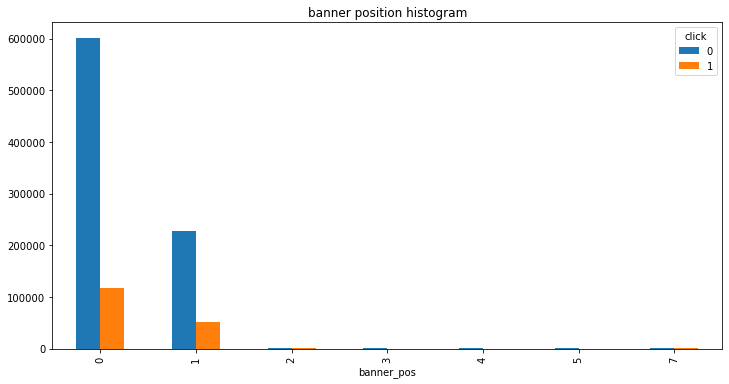

In [30]:
train.groupby(['banner_pos', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='banner position histogram');

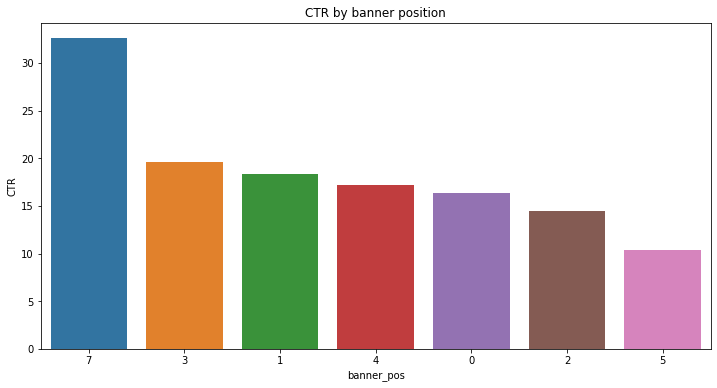

In [31]:
df_banner = train[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()
df_banner = df_banner.rename(columns={'click': 'impressions'})
df_banner['clicks'] = df_click[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()['click']
df_banner['CTR'] = df_banner['clicks']/df_banner['impressions']*100
sort_banners = df_banner.sort_values(by='CTR',ascending=False)['banner_pos'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='banner_pos', data=df_banner, order=sort_banners)
plt.title('CTR by banner position');

In [32]:
df_banner.CTR.describe()

count     7.000000
mean     18.418805
std       6.926886
min      10.400000
25%      15.399837
50%      17.187500
75%      18.980097
max      32.584270
Name: CTR, dtype: float64

Although banner position 0 and 1 have the highest number of impressions and clicks, banner 7 enjoys the highest click through rate. Increasing the number of ads placed on banner position 7 seems to be a good idea.

### Site features

#### site id

In [33]:
print("There are {} sites in the data set".format(train.site_id.nunique()))

There are 2660 sites in the data set


In [34]:
print('The top 10 site ids that have the most impressions')
print((train.site_id.value_counts()/len(train))[0:10])

The top 10 site ids that have the most impressions
85f751fd    0.360335
1fbe01fe    0.160042
e151e245    0.065321
d9750ee7    0.024076
5b08c53b    0.022407
5b4d2eda    0.019085
856e6d3f    0.018905
a7853007    0.011376
b7e9786d    0.009112
5ee41ff2    0.008739
Name: site_id, dtype: float64


In [35]:
top10_ids = (train.site_id.value_counts()/len(train))[0:10].index
click_avg_list=[]

for i in top10_ids:
    click_avg=train.loc[np.where((train.site_id == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for site id value: {},  click through rate: {}".format(i,click_avg))

for site id value: 85f751fd,  click through rate: 0.11888381644858256
for site id value: 1fbe01fe,  click through rate: 0.20434011072093575
for site id value: e151e245,  click through rate: 0.2979286906201681
for site id value: d9750ee7,  click through rate: 0.2847233759760758
for site id value: 5b08c53b,  click through rate: 0.46409604141562905
for site id value: 5b4d2eda,  click through rate: 0.12858265653654702
for site id value: 856e6d3f,  click through rate: 0.042263951335625494
for site id value: a7853007,  click through rate: 0.10249648382559776
for site id value: b7e9786d,  click through rate: 0.07287093942054433
for site id value: 5ee41ff2,  click through rate: 0.3248655452568944


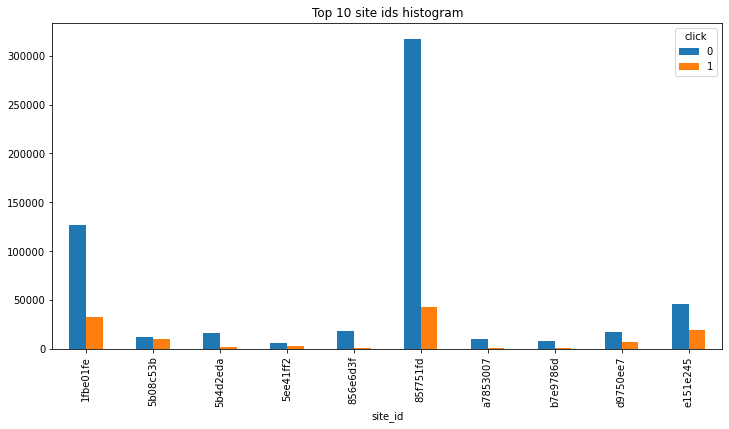

In [36]:
top10_sites = train[(train.site_id.isin((train.site_id.value_counts()/len(train))[0:10].index))]
top10_sites_click = top10_sites[top10_sites['click'] == 1]
top10_sites.groupby(['site_id', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 site ids histogram');

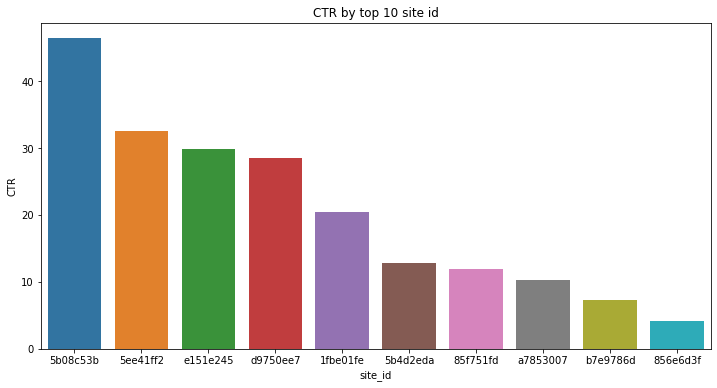

In [37]:
df_site = top10_sites[['site_id','click']].groupby(['site_id']).count().reset_index()
df_site = df_site.rename(columns={'click': 'impressions'})
df_site['clicks'] = top10_sites_click[['site_id','click']].groupby(['site_id']).count().reset_index()['click']
df_site['CTR'] = df_site['clicks']/df_site['impressions']*100
sort_site = df_site.sort_values(by='CTR',ascending=False)['site_id'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='site_id', data=df_site, order=sort_site)
plt.title('CTR by top 10 site id');

The site_id feature seems important because the CTR for the top 10 sites, some as high as 0.47, and some as low as 0.04, and they are significantly different from overall CTR 0.16.

#### site domain 

In [38]:
print("There are {} site domains in the data set".format(train.site_domain.nunique()))

There are 2848 site domains in the data set


In [39]:
print('The top 10 site domains that have the most impressions')
print((train.site_domain.value_counts()/len(train))[0:10])

The top 10 site domains that have the most impressions
c4e18dd6    0.373488
f3845767    0.160042
7e091613    0.082387
7687a86e    0.031782
98572c79    0.024902
16a36ef3    0.021146
58a89a43    0.018905
b12b9f85    0.009235
9d54950b    0.009175
17d996e6    0.008839
Name: site_domain, dtype: float64


In [40]:
top10_domains = (train.site_domain.value_counts()/len(train))[0:10].index
click_avg_list=[]

for i in top10_domains:
    click_avg=train.loc[np.where((train.site_domain == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for site domain value: {},  click through rate: {}".format(i,click_avg))

for site domain value: c4e18dd6,  click through rate: 0.12284464293364178
for site domain value: f3845767,  click through rate: 0.20434011072093575
for site domain value: 7e091613,  click through rate: 0.2597618556325634
for site domain value: 7687a86e,  click through rate: 0.45780630545591844
for site domain value: 98572c79,  click through rate: 0.27865231708296523
for site domain value: 16a36ef3,  click through rate: 0.14002648254989122
for site domain value: 58a89a43,  click through rate: 0.042263951335625494
for site domain value: b12b9f85,  click through rate: 0.07406605305901462
for site domain value: 9d54950b,  click through rate: 0.10332425068119891
for site domain value: 17d996e6,  click through rate: 0.32266093449485234


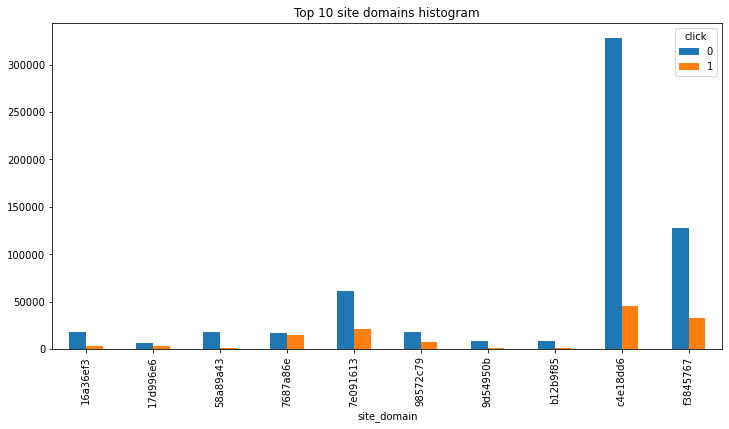

In [41]:
top10_domain = train[(train.site_domain.isin((train.site_domain.value_counts()/len(train))[0:10].index))]
top10_domain_click = top10_domain[top10_domain['click'] == 1]
top10_domain.groupby(['site_domain', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 site domains histogram');

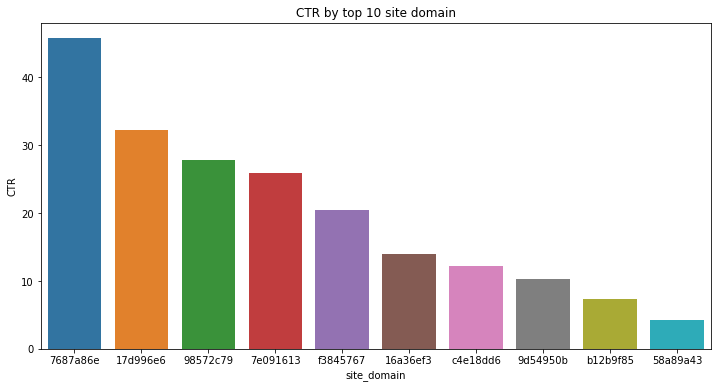

In [42]:
df_domain = top10_domain[['site_domain','click']].groupby(['site_domain']).count().reset_index()
df_domain = df_domain.rename(columns={'click': 'impressions'})
df_domain['clicks'] = top10_domain_click[['site_domain','click']].groupby(['site_domain']).count().reset_index()['click']
df_domain['CTR'] = df_domain['clicks']/df_domain['impressions']*100
sort_domain = df_domain.sort_values(by='CTR',ascending=False)['site_domain'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='site_domain', data=df_domain, order=sort_domain)
plt.title('CTR by top 10 site domain');

Similar with the site_id feature, the site_domain feature seems important as well.

#### site category

In [43]:
print("There are {} site categories in the data set".format(train.site_category.nunique()))

There are 22 site categories in the data set


In [44]:
print('The top 10 site categories that have the most impressions')
print((train.site_category.value_counts()/len(train))[0:10])

The top 10 site categories that have the most impressions
50e219e0    0.408110
f028772b    0.313988
28905ebd    0.182359
3e814130    0.075492
f66779e6    0.006185
75fa27f6    0.003972
335d28a8    0.003429
76b2941d    0.002685
c0dd3be3    0.001042
72722551    0.000730
Name: site_category, dtype: float64


In [45]:
top10_categories = (train.site_category.value_counts()/len(train))[0:10].index
click_avg_list=[]

for i in top10_categories:
    click_avg=train.loc[np.where((train.site_category == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for site category value: {},  click through rate: {}".format(i,click_avg))

for site category value: 50e219e0,  click through rate: 0.12871284702653696
for site category value: f028772b,  click through rate: 0.17951004496987147
for site category value: 28905ebd,  click through rate: 0.20667474596811783
for site category value: 3e814130,  click through rate: 0.281288083505537
for site category value: f66779e6,  click through rate: 0.038965238480194016
for site category value: 75fa27f6,  click through rate: 0.10750251762336355
for site category value: 335d28a8,  click through rate: 0.09827938174394868
for site category value: 76b2941d,  click through rate: 0.02867783985102421
for site category value: c0dd3be3,  click through rate: 0.11036468330134357
for site category value: 72722551,  click through rate: 0.06438356164383562


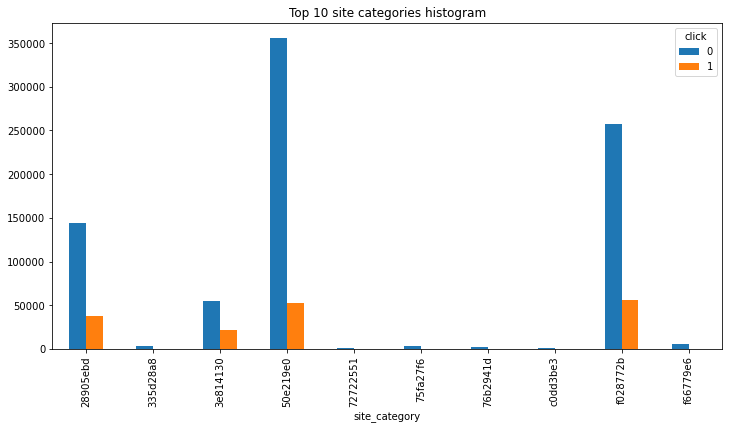

In [46]:
top10_category = train[(train.site_category.isin((train.site_category.value_counts()/len(train))[0:10].index))]
top10_category_click = top10_category[top10_category['click'] == 1]
top10_category.groupby(['site_category', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 site categories histogram');

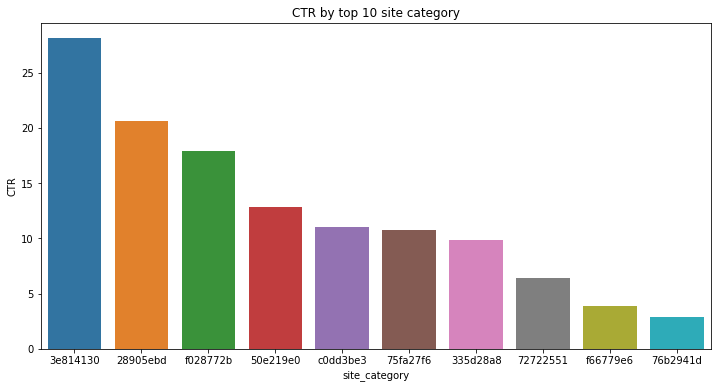

In [47]:
df_category = top10_category[['site_category','click']].groupby(['site_category']).count().reset_index()
df_category = df_category.rename(columns={'click': 'impressions'})
df_category['clicks'] = top10_category_click[['site_category','click']].groupby(['site_category']).count().reset_index()['click']
df_category['CTR'] = df_category['clicks']/df_category['impressions']*100
sort_category = df_category.sort_values(by='CTR',ascending=False)['site_category'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='site_category', data=df_category, order=sort_category)
plt.title('CTR by top 10 site category');

### Device features

#### device id

In [48]:
print("There are {} devices in the data set".format(train.device_id.nunique()))

There are 150044 devices in the data set


In [49]:
print('The top 10 devices that have the most impressions')
print((train.device_id.value_counts()/len(train))[0:10])

The top 10 devices that have the most impressions
a99f214a    0.825575
c357dbff    0.000495
0f7c61dc    0.000484
936e92fb    0.000348
afeffc18    0.000244
28dc8687    0.000103
d857ffbb    0.000097
987552d1    0.000093
b09da1c4    0.000087
cef4c8cc    0.000082
Name: device_id, dtype: float64


In [50]:
top10_devices = (train.device_id.value_counts()/len(train))[0:10].index
click_avg_list=[]

for i in top10_devices:
    click_avg=train.loc[np.where((train.device_id == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for device id value: {},  click through rate: {}".format(i,click_avg))

for device id value: a99f214a,  click through rate: 0.17357235865911638
for device id value: c357dbff,  click through rate: 0.6646464646464646
for device id value: 0f7c61dc,  click through rate: 0.768595041322314
for device id value: 936e92fb,  click through rate: 0.09195402298850575
for device id value: afeffc18,  click through rate: 0.26229508196721313
for device id value: 28dc8687,  click through rate: 0.0
for device id value: d857ffbb,  click through rate: 0.32989690721649484
for device id value: 987552d1,  click through rate: 0.0
for device id value: b09da1c4,  click through rate: 0.14942528735632185
for device id value: cef4c8cc,  click through rate: 0.21951219512195122


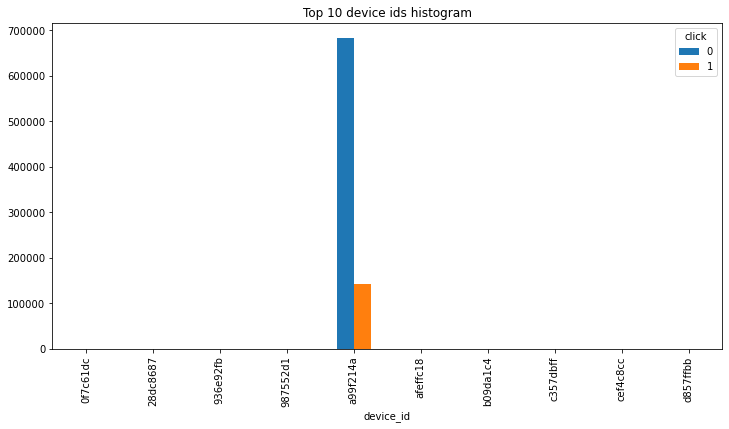

In [51]:
top10_device = train[(train.device_id.isin((train.device_id.value_counts()/len(train))[0:10].index))]
top10_device_click = top10_device[top10_device['click'] == 1]
top10_device.groupby(['device_id', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 device ids histogram');

You will see that most of device_id is a99f214a : Approx. 83% of the data, and the second major device_id is only 0.05% of the data. And there are some extremely high CTR here with device id at 0f7c61dc.

#### device ip

Device ip is more of a users ip address, so, there are a lot of them.

In [52]:
print("There are {} device ips in the data set".format(train.device_ip.nunique()))
print("There are {} device types in the data set".format(train.device_type.nunique()))
print("There are {} device models in the data set".format(train.device_model.nunique()))
print("There are {} device cnn types in the data set".format(train.device_conn_type.nunique()))

There are 555454 device ips in the data set
There are 5 device types in the data set
There are 5179 device models in the data set
There are 4 device cnn types in the data set


#### device type

In [53]:
print('The impressions by device types')
print((train.device_type.value_counts()/len(train)))

The impressions by device types
1    0.922920
0    0.054711
4    0.019156
5    0.003211
2    0.000002
Name: device_type, dtype: float64


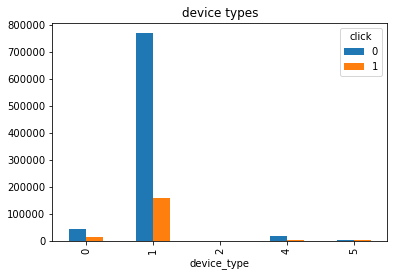

In [54]:
train[['device_type','click']].groupby(['device_type','click']).size().unstack().plot(kind='bar', title='device types');

Device type 1 gets the most impressions and clicks. And the other device types only get the minimum impressions and clicks. We may want to look in more details about device type 1. 

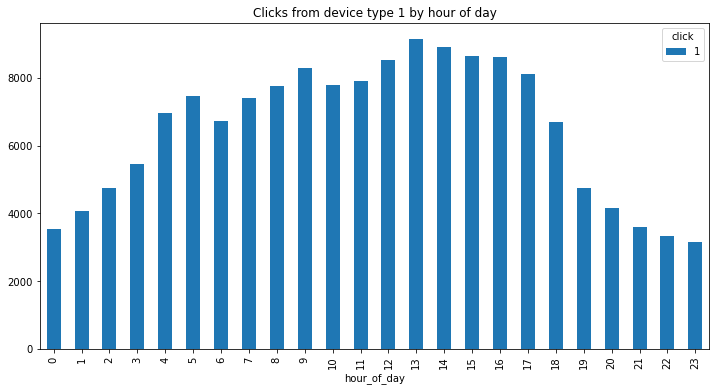

In [55]:
df_click[df_click['device_type']==1].groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar', title="Clicks from device type 1 by hour of day", figsize=(12,6));

As expected, most clicks happened during the business hours from device type 1. device type is definitely an important feature. 

In [56]:
device_type_click = df_click.groupby('device_type').agg({'click':'sum'}).reset_index()
device_type_impression = train.groupby('device_type').agg({'click':'count'}).reset_index().rename(columns={'click': 'impressions'})
merged_device_type = pd.merge(left = device_type_click , right = device_type_impression, how = 'inner', on = 'device_type')

In [57]:
merged_device_type['CTR'] = merged_device_type['click'] / merged_device_type['impressions']*100

In [58]:
merged_device_type

,device_type,click,impressions,CTR
0,0,11540,54711,21.092650
1,1,155796,922920,16.880770
2,4,1860,19156,9.709752
3,5,300,3211,9.342884


The highest CTR comes from device type 0.

#### app features

In [59]:
print("There are {} apps in the data set".format(train.app_id.nunique()))
print("There are {} app domains in the data set".format(train.app_domain.nunique()))
print("There are {} app categories in the data set".format(train.app_category.nunique()))

There are 3114 apps in the data set
There are 193 app domains in the data set
There are 26 app categories in the data set


Looks like app category something worth to explore.

In [60]:
print('The impressions by app categories')
print((train.app_category.value_counts()/len(train)))

The impressions by app categories
07d7df22    0.647829
0f2161f8    0.236183
cef3e649    0.042961
8ded1f7a    0.036126
f95efa07    0.027941
d1327cf5    0.003067
dc97ec06    0.001377
09481d60    0.001298
75d80bbe    0.001018
fc6fa53d    0.000576
4ce2e9fc    0.000526
879c24eb    0.000321
a3c42688    0.000281
4681bb9d    0.000153
0f9a328c    0.000138
2281a340    0.000059
a86a3e89    0.000058
8df2e842    0.000037
a7fd01ec    0.000013
79f0b860    0.000009
0bfbc358    0.000009
2fc4f2aa    0.000006
7113d72a    0.000006
18b1e0be    0.000006
71af18ce    0.000001
4b7ade46    0.000001
Name: app_category, dtype: float64


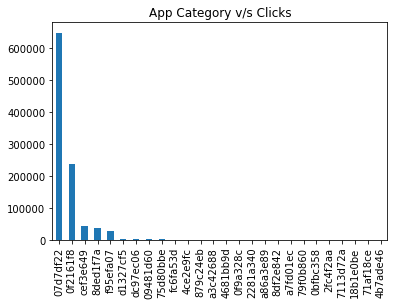

In [61]:
train['app_category'].value_counts().plot(kind='bar', title='App Category v/s Clicks')

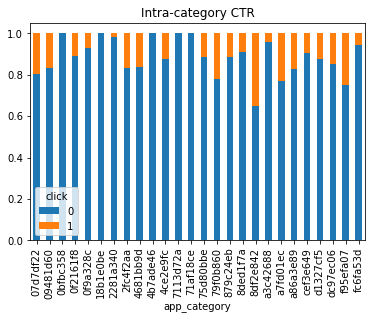

In [62]:
train_app_category = train.groupby(['app_category', 'click']).size().unstack()
train_app_category.div(train_app_category.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="Intra-category CTR");

#### C14 - C21 features

In [63]:
print("There are {} C14 in the data set".format(train.C14.nunique()))
print("There are {} C15 in the data set".format(train.C15.nunique()))
print("There are {} C16 in the data set".format(train.C16.nunique()))
print("There are {} C17 in the data set".format(train.C17.nunique()))
print("There are {} C18 in the data set".format(train.C18.nunique()))
print("There are {} C19 in the data set".format(train.C19.nunique()))
print("There are {} C20 in the data set".format(train.C20.nunique()))

There are 2246 C14 in the data set
There are 8 C15 in the data set
There are 9 C16 in the data set
There are 421 C17 in the data set
There are 4 C18 in the data set
There are 66 C19 in the data set
There are 163 C20 in the data set


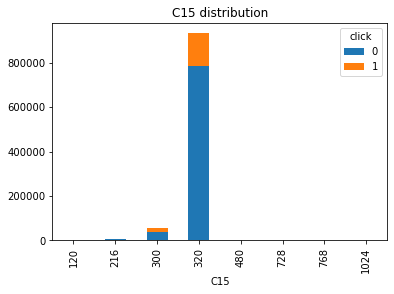

In [64]:
train.groupby(['C15', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C15 distribution');

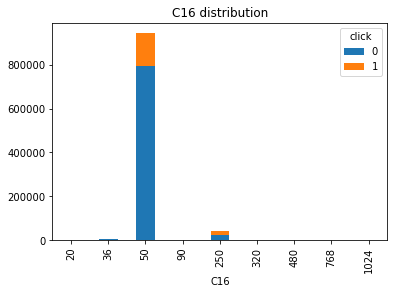

In [65]:
train.groupby(['C16', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C16 distribution');

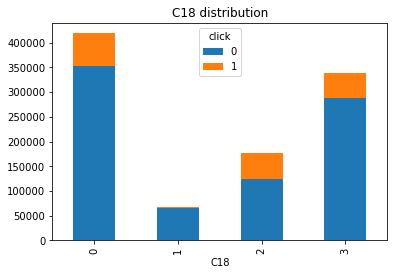

In [66]:
train.groupby(['C18', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C18 distribution');

In [67]:
train.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week
0,10012820175855462623,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,15707,320,50,1722,0,35,-1,79,0,Tuesday
1,10015405794859644629,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,15701,320,50,1722,0,35,100084,79,0,Tuesday
2,1001795364355496701,0,2014-10-21,1005,1,b7e9786d,b12b9f85,f028772b,ecad2386,7801e8d9,...,19771,320,50,2227,0,687,100081,48,0,Tuesday


In [68]:
def convert_obj_to_int(self):
    
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] == object :
            self[object_list_columns[index]+new_col_suffix] = self[object_list_columns[index]].map( lambda  x: hash(x))
            self.drop([object_list_columns[index]],inplace=True,axis=1)
    return self
train = convert_obj_to_int(train)

In [69]:
train.head(3)

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,...,site_id_int,site_domain_int,site_category_int,app_id_int,app_domain_int,app_category_int,device_id_int,device_ip_int,device_model_int,day_of_week_int
0,10012820175855462623,0,2014-10-21,1005,0,1,0,15707,320,50,...,8072457858668009690,-7405404455991950218,5741714047829778229,340817439802058328,944818851713017526,-4447912990114365011,6538910332837309378,-2771980042149229092,5596472927274993678,3948143323723306047
1,10015405794859644629,1,2014-10-21,1005,0,1,0,15701,320,50,...,8072457858668009690,-7405404455991950218,5741714047829778229,340817439802058328,944818851713017526,-4447912990114365011,6538910332837309378,-557174840053327132,5596472927274993678,3948143323723306047
2,1001795364355496701,0,2014-10-21,1005,1,1,0,19771,320,50,...,2475699607124947696,7209632983223013193,8476623325361461152,340817439802058328,944818851713017526,-4447912990114365011,6538910332837309378,5565457902063077128,-1227248255125870992,3948143323723306047


In [70]:
train.drop('hour', axis=1, inplace=True)

In [71]:
train.drop('id', axis=1, inplace=True)

In [72]:
import lightgbm as lgb
X_train = train.loc[:, train.columns != 'click']
y_target = train.click.values
#create lightgbm dataset
msk = np.random.rand(len(X_train)) < 0.8
lgb_train = lgb.Dataset(X_train[msk], y_target[msk])
lgb_eval = lgb.Dataset(X_train[~msk], y_target[~msk], reference=lgb_train)

In [73]:
# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'binary_logloss'},
    'num_leaves': 31, # defauly leaves(31) amount for each tree
    'learning_rate': 0.08,
    'feature_fraction': 0.7, # will select 70% features before training each tree
    'bagging_fraction': 0.3, #feature_fraction, but this will random select part of data
    'bagging_freq': 5, #  perform bagging at every 5 iteration
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=lgb_eval,
                early_stopping_rounds=500)

Start training...
[1]	valid_0's binary_logloss: 0.450385
Training until validation scores don't improve for 500 rounds
[2]	valid_0's binary_logloss: 0.445813
[3]	valid_0's binary_logloss: 0.442091
[4]	valid_0's binary_logloss: 0.439006
[5]	valid_0's binary_logloss: 0.436297
[6]	valid_0's binary_logloss: 0.433887
[7]	valid_0's binary_logloss: 0.431882
[8]	valid_0's binary_logloss: 0.42999
[9]	valid_0's binary_logloss: 0.428378
[10]	valid_0's binary_logloss: 0.426764
[11]	valid_0's binary_logloss: 0.425372
[12]	valid_0's binary_logloss: 0.423931
[13]	valid_0's binary_logloss: 0.422874
[14]	valid_0's binary_logloss: 0.421921
[15]	valid_0's binary_logloss: 0.421014
[16]	valid_0's binary_logloss: 0.420296
[17]	valid_0's binary_logloss: 0.419595
[18]	valid_0's binary_logloss: 0.418929
[19]	valid_0's binary_logloss: 0.418362
[20]	valid_0's binary_logloss: 0.417841
[21]	valid_0's binary_logloss: 0.417416
[22]	valid_0's binary_logloss: 0.416896
[23]	valid_0's binary_logloss: 0.416324
[24]	valid

[203]	valid_0's binary_logloss: 0.403174
[204]	valid_0's binary_logloss: 0.403157
[205]	valid_0's binary_logloss: 0.403147
[206]	valid_0's binary_logloss: 0.40312
[207]	valid_0's binary_logloss: 0.403095
[208]	valid_0's binary_logloss: 0.403096
[209]	valid_0's binary_logloss: 0.403076
[210]	valid_0's binary_logloss: 0.403053
[211]	valid_0's binary_logloss: 0.403025
[212]	valid_0's binary_logloss: 0.402988
[213]	valid_0's binary_logloss: 0.402969
[214]	valid_0's binary_logloss: 0.402942
[215]	valid_0's binary_logloss: 0.402922
[216]	valid_0's binary_logloss: 0.402913
[217]	valid_0's binary_logloss: 0.402897
[218]	valid_0's binary_logloss: 0.40287
[219]	valid_0's binary_logloss: 0.40287
[220]	valid_0's binary_logloss: 0.402853
[221]	valid_0's binary_logloss: 0.402857
[222]	valid_0's binary_logloss: 0.402837
[223]	valid_0's binary_logloss: 0.402798
[224]	valid_0's binary_logloss: 0.402775
[225]	valid_0's binary_logloss: 0.402747
[226]	valid_0's binary_logloss: 0.40272
[227]	valid_0's bina

[410]	valid_0's binary_logloss: 0.401305
[411]	valid_0's binary_logloss: 0.4013
[412]	valid_0's binary_logloss: 0.401293
[413]	valid_0's binary_logloss: 0.401298
[414]	valid_0's binary_logloss: 0.401305
[415]	valid_0's binary_logloss: 0.401304
[416]	valid_0's binary_logloss: 0.401292
[417]	valid_0's binary_logloss: 0.401297
[418]	valid_0's binary_logloss: 0.401297
[419]	valid_0's binary_logloss: 0.401299
[420]	valid_0's binary_logloss: 0.401301
[421]	valid_0's binary_logloss: 0.401296
[422]	valid_0's binary_logloss: 0.401297
[423]	valid_0's binary_logloss: 0.401291
[424]	valid_0's binary_logloss: 0.401292
[425]	valid_0's binary_logloss: 0.401292
[426]	valid_0's binary_logloss: 0.401279
[427]	valid_0's binary_logloss: 0.40129
[428]	valid_0's binary_logloss: 0.401293
[429]	valid_0's binary_logloss: 0.401287
[430]	valid_0's binary_logloss: 0.401286
[431]	valid_0's binary_logloss: 0.401271
[432]	valid_0's binary_logloss: 0.401265
[433]	valid_0's binary_logloss: 0.401271
[434]	valid_0's bin

[616]	valid_0's binary_logloss: 0.400589
[617]	valid_0's binary_logloss: 0.400589
[618]	valid_0's binary_logloss: 0.40059
[619]	valid_0's binary_logloss: 0.400588
[620]	valid_0's binary_logloss: 0.400582
[621]	valid_0's binary_logloss: 0.400587
[622]	valid_0's binary_logloss: 0.40059
[623]	valid_0's binary_logloss: 0.40059
[624]	valid_0's binary_logloss: 0.400583
[625]	valid_0's binary_logloss: 0.400577
[626]	valid_0's binary_logloss: 0.400569
[627]	valid_0's binary_logloss: 0.400567
[628]	valid_0's binary_logloss: 0.400573
[629]	valid_0's binary_logloss: 0.400571
[630]	valid_0's binary_logloss: 0.400575
[631]	valid_0's binary_logloss: 0.400572
[632]	valid_0's binary_logloss: 0.400565
[633]	valid_0's binary_logloss: 0.40056
[634]	valid_0's binary_logloss: 0.400561
[635]	valid_0's binary_logloss: 0.400555
[636]	valid_0's binary_logloss: 0.400551
[637]	valid_0's binary_logloss: 0.400558
[638]	valid_0's binary_logloss: 0.400569
[639]	valid_0's binary_logloss: 0.40056
[640]	valid_0's binar

[824]	valid_0's binary_logloss: 0.400346
[825]	valid_0's binary_logloss: 0.400341
[826]	valid_0's binary_logloss: 0.400344
[827]	valid_0's binary_logloss: 0.400348
[828]	valid_0's binary_logloss: 0.400351
[829]	valid_0's binary_logloss: 0.400348
[830]	valid_0's binary_logloss: 0.400347
[831]	valid_0's binary_logloss: 0.400344
[832]	valid_0's binary_logloss: 0.400344
[833]	valid_0's binary_logloss: 0.400333
[834]	valid_0's binary_logloss: 0.400336
[835]	valid_0's binary_logloss: 0.400343
[836]	valid_0's binary_logloss: 0.400334
[837]	valid_0's binary_logloss: 0.400328
[838]	valid_0's binary_logloss: 0.400325
[839]	valid_0's binary_logloss: 0.400318
[840]	valid_0's binary_logloss: 0.40032
[841]	valid_0's binary_logloss: 0.400323
[842]	valid_0's binary_logloss: 0.400318
[843]	valid_0's binary_logloss: 0.400321
[844]	valid_0's binary_logloss: 0.400318
[845]	valid_0's binary_logloss: 0.400316
[846]	valid_0's binary_logloss: 0.40031
[847]	valid_0's binary_logloss: 0.400297
[848]	valid_0's bi

[1026]	valid_0's binary_logloss: 0.400423
[1027]	valid_0's binary_logloss: 0.400428
[1028]	valid_0's binary_logloss: 0.400433
[1029]	valid_0's binary_logloss: 0.400438
[1030]	valid_0's binary_logloss: 0.400439
[1031]	valid_0's binary_logloss: 0.400426
[1032]	valid_0's binary_logloss: 0.400422
[1033]	valid_0's binary_logloss: 0.400421
[1034]	valid_0's binary_logloss: 0.400413
[1035]	valid_0's binary_logloss: 0.400411
[1036]	valid_0's binary_logloss: 0.400414
[1037]	valid_0's binary_logloss: 0.400418
[1038]	valid_0's binary_logloss: 0.400413
[1039]	valid_0's binary_logloss: 0.400409
[1040]	valid_0's binary_logloss: 0.40041
[1041]	valid_0's binary_logloss: 0.400404
[1042]	valid_0's binary_logloss: 0.400389
[1043]	valid_0's binary_logloss: 0.400395
[1044]	valid_0's binary_logloss: 0.400395
[1045]	valid_0's binary_logloss: 0.400387
[1046]	valid_0's binary_logloss: 0.400386
[1047]	valid_0's binary_logloss: 0.400381
[1048]	valid_0's binary_logloss: 0.400372
[1049]	valid_0's binary_logloss: 0.

[1228]	valid_0's binary_logloss: 0.400332
[1229]	valid_0's binary_logloss: 0.400329
[1230]	valid_0's binary_logloss: 0.400323
[1231]	valid_0's binary_logloss: 0.400328
[1232]	valid_0's binary_logloss: 0.400329
[1233]	valid_0's binary_logloss: 0.400325
[1234]	valid_0's binary_logloss: 0.400319
[1235]	valid_0's binary_logloss: 0.400323
[1236]	valid_0's binary_logloss: 0.400319
[1237]	valid_0's binary_logloss: 0.400306
[1238]	valid_0's binary_logloss: 0.4003
[1239]	valid_0's binary_logloss: 0.400306
[1240]	valid_0's binary_logloss: 0.40031
[1241]	valid_0's binary_logloss: 0.400308
[1242]	valid_0's binary_logloss: 0.400304
[1243]	valid_0's binary_logloss: 0.400294
[1244]	valid_0's binary_logloss: 0.400292
[1245]	valid_0's binary_logloss: 0.400297
[1246]	valid_0's binary_logloss: 0.400302
[1247]	valid_0's binary_logloss: 0.400297
[1248]	valid_0's binary_logloss: 0.400296
[1249]	valid_0's binary_logloss: 0.400309
[1250]	valid_0's binary_logloss: 0.400312
[1251]	valid_0's binary_logloss: 0.40

In [74]:
print(gbm.best_score)
print(gbm.best_iteration)

defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('binary_logloss', 0.40025644666726684)])})
865


In [75]:
from operator import itemgetter
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score

def run_default_test(train, test, features, target, random_state=0):
    eta = 0.1
    max_depth = 5
    subsample = 0.8
    colsample_bytree = 0.8
    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "logloss",
        "eta": eta,
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "seed": random_state
    }
    num_boost_round = 260
    early_stopping_rounds = 20
    test_size = 0.2

    X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    y_train = X_train[target]
    y_valid = X_valid[target]
    dtrain = xgb.DMatrix(X_train[features], y_train)
    dvalid = xgb.DMatrix(X_valid[features], y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

In [76]:
features = ['C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hour_of_day',
       'site_id_int', 'site_domain_int', 'site_category_int', 'app_id_int',
       'app_domain_int', 'app_category_int', 'device_id_int', 'device_ip_int',
       'device_model_int', 'day_of_week_int']
run_default_test(train, y_target, features, 'click')

XGBoost params. ETA: 0.1, MAX_DEPTH: 5, SUBSAMPLE: 0.8, COLSAMPLE_BY_TREE: 0.8


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-logloss:0.648726	eval-logloss:0.648645
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 20 rounds.
[1]	train-logloss:0.61202	eval-logloss:0.612008
[2]	train-logloss:0.581847	eval-logloss:0.581833
[3]	train-logloss:0.556902	eval-logloss:0.556745
[4]	train-logloss:0.535943	eval-logloss:0.535772
[5]	train-logloss:0.518405	eval-logloss:0.518366
[6]	train-logloss:0.503435	eval-logloss:0.503385
[7]	train-logloss:0.491121	eval-logloss:0.491099
[8]	train-logloss:0.480451	eval-logloss:0.480407
[9]	train-logloss:0.47132	eval-logloss:0.471433
[10]	train-logloss:0.463852	eval-logloss:0.463932
[11]	train-logloss:0.457231	eval-logloss:0.457329
[12]	train-logloss:0.45191	eval-logloss:0.451927
[13]	train-logloss:0.44725	eval-logloss:0.447283
[14]	train-logloss:0.443077	eval-logloss:0.443113
[15]	train-logloss:0.43929	eval-logloss:0.439413
[16]	train-logloss:0.436083	eval-logloss:0.436218
[17]	train-loglo

[161]	train-logloss:0.402706	eval-logloss:0.404943
[162]	train-logloss:0.402684	eval-logloss:0.404934
[163]	train-logloss:0.402651	eval-logloss:0.404931
[164]	train-logloss:0.402593	eval-logloss:0.404888
[165]	train-logloss:0.402534	eval-logloss:0.404847
[166]	train-logloss:0.402514	eval-logloss:0.404839
[167]	train-logloss:0.402478	eval-logloss:0.404816
[168]	train-logloss:0.402447	eval-logloss:0.404795
[169]	train-logloss:0.402424	eval-logloss:0.404779
[170]	train-logloss:0.402395	eval-logloss:0.404763
[171]	train-logloss:0.402369	eval-logloss:0.404738
[172]	train-logloss:0.402328	eval-logloss:0.404707
[173]	train-logloss:0.402293	eval-logloss:0.404683
[174]	train-logloss:0.402263	eval-logloss:0.404666
[175]	train-logloss:0.402196	eval-logloss:0.40461
[176]	train-logloss:0.40214	eval-logloss:0.404557
[177]	train-logloss:0.402091	eval-logloss:0.404519
[178]	train-logloss:0.402031	eval-logloss:0.404472
[179]	train-logloss:0.402011	eval-logloss:0.404463
[180]	train-logloss:0.401971	eval